In [46]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import numpy as np
import os 
from datetime import datetime

In [47]:
# Earth's radius
EARTH_RADIUS_KM = 6371
# Centimeters to kilometers
CM_TO_KM_RATIO = 1e-5
# Here, input the file path to the base data directory
BASE_DIR = 'D:\Groundwater Vulnerability Mapping\data'
# Figure size
FIG_SIZE = (10, 10)

In [48]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

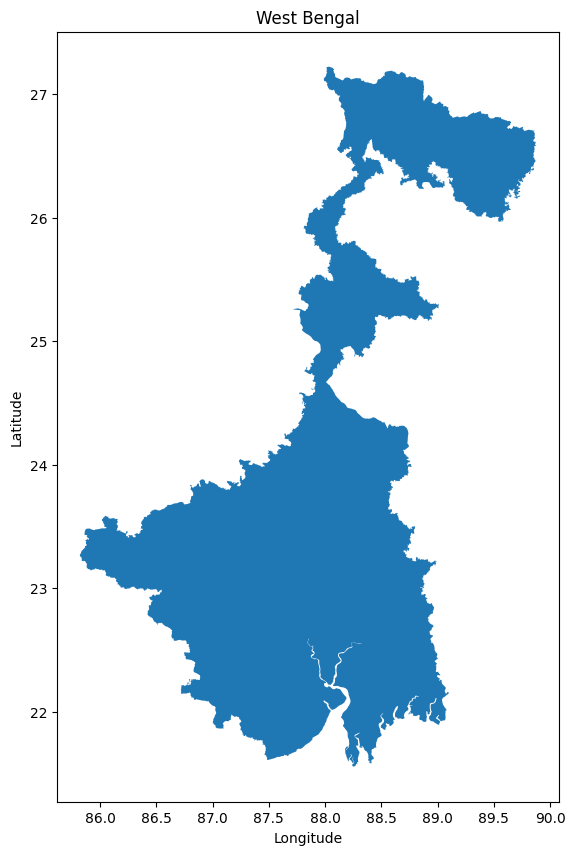

In [49]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


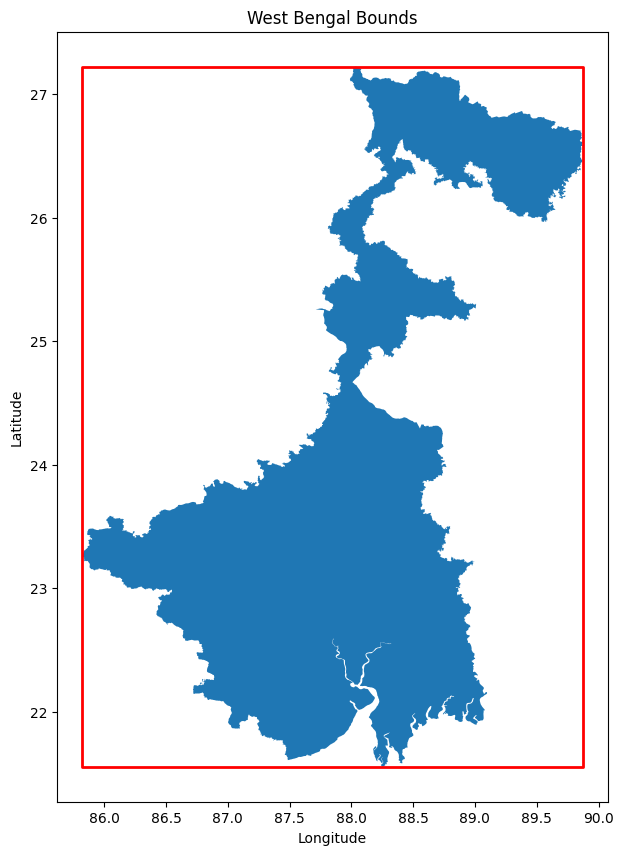

In [50]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [51]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, r"RAW Data\GRACE\GRCTellus.JPL.200204_202505.GLO.RL06.3M.MSCNv04CRI.nc"))

# print out grace data. Our varibale of interest (lwe_thickness) is measured in centimeters 
grace


<xarray.Dataset> Size: 2GB
Dimensions:        (lon: 720, lat: 360, time: 245, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-05-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 508MB ...
    uncertainty    (time, lat, lon) float64 508MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 508MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.3Mv04 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2025-07-09T14:07:30Z

In [52]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [53]:
# Subset GRACE data to WB region BEFORE converting to DataFrame
grace = grace.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)

In [54]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
0,86.25,21.75,2002-04-17 12:00:00,-27.015066,23.527598,0.921817
735,86.25,23.25,2002-04-17 12:00:00,-12.003431,22.887817,0.967227
1225,86.25,24.25,2002-04-17 12:00:00,-12.003431,22.887817,1.001268
16660,89.25,22.75,2002-04-17 12:00:00,-13.789784,22.970621,0.860325
8820,87.75,23.25,2002-04-17 12:00:00,-12.003431,22.887817,1.054784
...,...,...,...,...,...,...
14944,88.75,24.25,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15189,88.75,24.75,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15434,88.75,25.25,2025-05-16 12:00:00,-30.284789,14.307988,1.027741
13474,88.25,26.75,2025-05-16 12:00:00,-69.313839,10.175189,0.930138


In [55]:
# Compute surface area for pixel with dimensions n x n degree. Note the area of a pixel changes with respect to latitude!
degree_measure = 0.5
grace_df['surface_area_km2'] = EARTH_RADIUS_KM * np.radians(degree_measure) * EARTH_RADIUS_KM * np.radians(degree_measure) * np.cos(np.radians(grace_df['lat']))

# Convert units from cm to km^3
grace_df["lwe_thickness_km3"] = grace_df["lwe_thickness_cm"]  * CM_TO_KM_RATIO * grace_df['surface_area_km2'] * grace_df['scale_factor']
grace_df['uncertainty_km3'] = grace_df["uncertainty_cm"] * CM_TO_KM_RATIO * grace_df['surface_area_km2']

In [56]:
import geopandas as gpd

print("Starting precise clip for GRACE data...")

# --- Step 1: Convert your grace_df into a GeoDataFrame ---
# This gives each row a geographic point based on its lat/lon
grace_gdf = gpd.GeoDataFrame(
    grace_df,
    crs='epsg:4326',
    geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat'])
)

# --- Step 2: Ensure basin shapefile is ready ---
# This assumes 'basin_shapefile' is already loaded from your first step
basin_shapefile = basin_shapefile.to_crs('epsg:4326')

# --- Step 3: Perform the spatial join (the "clip") ---
# This keeps only the points from the GRACE data that are inside the basin_shapefile
grace_clipped_df = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 4: Clean up and select the final columns ---
final_grace_columns = ['time', 'lat', 'lon', 'lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'surface_area_km2', 'lwe_thickness_km3', 'uncertainty_km3']
grace_final_df = grace_clipped_df[final_grace_columns]

# --- Step 5: Save the final processed file ---
grace_output_filename = 'grace_processed_clipped.csv'
grace_final_df.to_csv(grace_output_filename, index=False)

print(f"\n✅ SUCCESS: The file '{grace_output_filename}' has been created.")
print("\n--- Preview of the final, clipped GRACE data ---")
print(grace_final_df.head())

Starting precise clip for GRACE data...

✅ SUCCESS: The file 'grace_processed_clipped.csv' has been created.

--- Preview of the final, clipped GRACE data ---
                     time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
735   2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
8820  2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
9065  2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
9310  2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
18620 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

       scale_factor  surface_area_km2  lwe_thickness_km3  uncertainty_km3  
735        0.967227       2840.055230          -0.329731         0.650027  
8820       1.054784       2840.055230          -0.359580         0.650027  
9065       1.054784       2829.299110          -0.358218         0.647565  
9310       0.955446       2818.327528          -0.323223         0.645054 

In [57]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_NOAH025_M_2.1-20250814_151559\GLDAS_NOAH025_M.A200001.021.nc4")

<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst           (time, lat, lon) float32 3MB ...
    SWdown_f_tavg          (time, lat, lon) float32 3MB ...
    LWdown_f_tavg          (time, lat, lon) float32 3MB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [58]:
import pandas as pd
import xarray as xr
import os

# Define the path to your GLDAS files
gldas_path = r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_NOAH025_M_2.1-20250814_151559"

# Create an empty DataFrame to store the combined data
gldas_df = pd.DataFrame()

# Define the list of soil moisture layers to sum
soil_layers = [
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilMoi40_100cm_inst', 
    'SoilMoi100_200cm_inst'
]

print("Starting memory-efficient GLDAS data processing...")
# Iterate through each file in the directory
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        file_path = os.path.join(gldas_path, filename)
        
        # 1. Reading in data as xarray
        xd = xr.open_dataset(file_path)

        # 2. Filter the xarray object FIRST (this is memory-efficient)
        xd_subset = xd.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

        # 3. Convert only the SMALL SUBSET to a DataFrame
        xd_df = xd_subset.to_dataframe()
        xd_df.reset_index(inplace=True)

        # 4. Perform your calculations on the small DataFrame
        xd_df['SoilMoi0_200cm_inst'] = xd_df[soil_layers].sum(axis=1)

        # Extract only the columns you need
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "Qs_acc", "SoilMoi0_200cm_inst"]]
        df_slice = df_slice.drop_duplicates()

        # Append the data for this month to the main DataFrame
        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

# Rename the columns to include units for clarity
gldas_df = gldas_df.rename(columns={
    'SWE_inst': 'SWE_inst_kg/m2',
    'Qs_acc': 'Qs_acc_kg/m2',
    'SoilMoi0_200cm_inst': 'TotalSoilMoisture_kg/m2'
})

print("\n✅ GLDAS data processing complete.")
print("\n--- Preview of the Final GLDAS Data ---")
print(gldas_df.head())

Starting memory-efficient GLDAS data processing...

✅ GLDAS data processing complete.

--- Preview of the Final GLDAS Data ---
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  
0               402.055817  
1               411.130768  
2               415.805115  
3               629.142212  
4               634.998657  


In [59]:
import numpy as np

# --- Step 1: Define Constants ---
# The ratio to convert a 1 mm depth over a 1 km^2 area to a volume in km^3.
# (1 kg/m^2 -> 1 mm -> 1e-6 km).
KG_M2_to_KM3_RATIO = 1e-6 

# --- Step 2: Calculate Pixel Surface Area ---
# GLDAS resolution is 0.25 degrees. This calculates the area for each pixel in km^2.
print("Calculating pixel surface area...")
degree_measure = 0.25
gldas_df['surface_area_km2'] = EARTH_RADIUS_KM * np.radians(degree_measure) * EARTH_RADIUS_KM * np.radians(degree_measure) * np.cos(np.radians(gldas_df['lat']))

# --- Step 3: Convert Units from kg/m^2 to km^3 ---
print("Converting all variables to volume (km^3)...")

# Apply the conversion to your Total Soil Moisture column
gldas_df['TotalSoilMoisture_km3'] = gldas_df['TotalSoilMoisture_kg/m2'] * gldas_df['surface_area_km2'] * KG_M2_to_KM3_RATIO

# Apply the conversion to your Snow Water Equivalent column
gldas_df['SWE_km3'] = gldas_df['SWE_inst_kg/m2'] * gldas_df['surface_area_km2'] * KG_M2_to_KM3_RATIO

# Apply the conversion to your Runoff column
gldas_df['Qs_acc_km3'] = gldas_df['Qs_acc_kg/m2'] * gldas_df['surface_area_km2'] * KG_M2_to_KM3_RATIO

print("\n✅ Unit conversion complete.")
print("\n--- Preview of Data with Volume Columns ---")
# Display the DataFrame with the new volume columns
print(gldas_df.head())

Calculating pixel surface area...
Converting all variables to volume (km^3)...

✅ Unit conversion complete.

--- Preview of Data with Volume Columns ---
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  surface_area_km2  TotalSoilMoisture_km3  SWE_km3  \
0               402.055817        718.378723               0.288828      0.0   
1               411.130768        717.129211               0.294834      0.0   
2               415.805115        715.866089               0.297661      0.0   
3               629.142212        714.589417               0.449578      0.0   
4               634.998657        713.299072               0.452944      0

In [60]:
import geopandas as gpd

print("Starting precise clip for GLDAS data...")

# --- Step 1: Convert your gldas_df into a GeoDataFrame ---
gldas_gdf = gpd.GeoDataFrame(
    gldas_df,
    crs='epsg:4326',  # CORRECTED: Removed the underscore
    geometry=gpd.points_from_xy(gldas_df['lon'], gldas_df['lat'])
)

# --- Step 2: Perform the spatial join (the "clip") ---
# Get the list of original columns BEFORE the join
original_gldas_columns = gldas_gdf.columns.tolist()

# Perform the join
gldas_clipped_df = gpd.sjoin(gldas_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 3: Clean up the final DataFrame ---
# Select ONLY the original columns to remove the extra ones from the shapefile
gldas_final_df = gldas_clipped_df[original_gldas_columns]

print("\n✅ GLDAS data has been successfully clipped to the basin.")
print("\n--- Preview of the final, clipped GLDAS data (with all columns) ---")
print(gldas_final_df.head())

Starting precise clip for GLDAS data...

✅ GLDAS data has been successfully clipped to the basin.

--- Preview of the final, clipped GLDAS data (with all columns) ---
         time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
7  2000-01-01  85.875  23.375             0.0      0.000048   
29 2000-01-01  86.125  23.125             0.0      0.000061   
30 2000-01-01  86.125  23.375             0.0      0.000035   
52 2000-01-01  86.375  23.125             0.0      0.000043   
53 2000-01-01  86.375  23.375             0.0      0.000044   

    TotalSoilMoisture_kg/m2  surface_area_km2  TotalSoilMoisture_km3  SWE_km3  \
7                450.469360        709.346619               0.319539      0.0   
29               458.309387        710.677612               0.325710      0.0   
30               419.461182        709.346619               0.297543      0.0   
52               421.693817        710.677612               0.299688      0.0   
53               433.443512        709.346619    

In [61]:
# Define a name for your output file
output_filename = 'gldas_NOAH_clipped_high_resolution.csv'

# Save the gldas_final_df DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
gldas_final_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the clipped high-resolution GLDAS data to '{output_filename}'")

✅ Successfully saved the clipped high-resolution GLDAS data to 'gldas_NOAH_clipped_high_resolution.csv'


In [62]:
import pandas as pd
import xarray as xr

# --- Step 1: Load your high-resolution clipped data ---
high_res_filename = 'gldas_NOAH_clipped_high_resolution.csv'
gldas_final_df = pd.read_csv(high_res_filename)
gldas_final_df['time'] = pd.to_datetime(gldas_final_df['time'])

# --- Step 2: Convert DataFrame to an xarray Dataset ---
print("Converting data to a grid format...")
# This step is the same
gldas_xr = gldas_final_df.set_index(['time', 'lat', 'lon']).to_xarray()

# --- Step 3: Coarsen the grid from 0.25° to 0.5° ---
print("Downscaling data from 0.25° to 0.5° resolution...")

# THE FIX IS HERE: Define and select only the numeric variables to process
numeric_variables = [
    'TotalSoilMoisture_kg/m2', 'SWE_inst_kg/m2', 'Qs_acc_kg/m2', 
    'surface_area_km2', 'TotalSoilMoisture_km3', 'SWE_km3', 'Qs_acc_km3'
]
gldas_numeric_xr = gldas_xr[numeric_variables]

# Now, perform the coarsen and sum operation ONLY on the numeric data
coarsening_factor = 2
gldas_downscaled_xr = gldas_numeric_xr.coarsen(
    lon=coarsening_factor, 
    lat=coarsening_factor, 
    boundary='trim'
).sum()

# --- Step 4: Convert the downscaled data back to a DataFrame ---
gldas_downscaled_df = gldas_downscaled_xr.to_dataframe().reset_index()

print("\n✅ Downscaling complete.")
print("\n--- Preview of the Final, Downscaled GLDAS Data ---")
print(gldas_downscaled_df.head())

Converting data to a grid format...
Downscaling data from 0.25° to 0.5° resolution...

✅ Downscaling complete.

--- Preview of the Final, Downscaled GLDAS Data ---
        time   lat   lon  TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  \
0 2000-01-01  22.0  86.0                  0.00000             0.0   
1 2000-01-01  22.0  86.5                  0.00000             0.0   
2 2000-01-01  22.0  87.0                925.74454             0.0   
3 2000-01-01  22.0  87.5               2121.57678             0.0   
4 2000-01-01  22.0  88.0               2104.78141             0.0   

   Qs_acc_kg/m2  surface_area_km2  TotalSoilMoisture_km3  SWE_km3  \
0      0.000000            0.0000               0.000000      0.0   
1      0.000000            0.0000               0.000000      0.0   
2      0.000069         1431.7322               0.662709      0.0   
3      0.000264         2865.9906               1.520221      0.0   
4      0.000753         2148.8614               1.507618      0.0   

     Q

In [63]:
# Define a name for your final, downscaled GLDAS file
output_filename = 'gldas_NOAH_final_downscaled0.5.csv'

# Save the gldas_downscaled_df DataFrame to a CSV file
gldas_downscaled_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the final downscaled GLDAS data to '{output_filename}'")

✅ Successfully saved the final downscaled GLDAS data to 'gldas_NOAH_final_downscaled0.5.csv'


In [64]:
import pandas as pd
import xarray as xr

# --- Step 1: Load both of your final processed datasets ---
print("Loading processed GRACE and GLDAS data...")
grace_df = pd.read_csv('grace_processed_clipped.csv')
gldas_df = pd.read_csv('gldas_NOAH_final_downscaled0.5.csv')

# Ensure time columns are in datetime format
grace_df['time'] = pd.to_datetime(grace_df['time'])
gldas_df['time'] = pd.to_datetime(gldas_df['time'])

# --- Step 2: Align the coordinate grids using xarray ---
print("Aligning coordinate grids for a perfect merge...")

# Convert both DataFrames to xarray Datasets
grace_xr = grace_df.set_index(['time', 'lat', 'lon']).to_xarray()
gldas_xr = gldas_df.set_index(['time', 'lat', 'lon']).to_xarray()

# Reindex the GLDAS data to match the GRACE coordinates exactly
gldas_aligned_xr = gldas_xr.reindex_like(grace_xr, method='nearest')

# --- Step 3: Merge the aligned data ---
# Convert the aligned GLDAS data back to a DataFrame
gldas_aligned_df = gldas_aligned_xr.to_dataframe().reset_index()

# Now, merge the original GRACE df with the ALIGNED GLDAS df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    gldas_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)


# Drop the redundant surface area column from the GLDAS data ('_y')
final_merged_df = final_merged_df.drop(columns=['surface_area_km2_y'])

# Rename the primary surface area column from GRACE ('_x') back to a clean name
final_merged_df = final_merged_df.rename(columns={'surface_area_km2_x': 'surface_area_km2'})



# --- Step 4: Save the final master file ---
final_output_filename = 'grace_gldas_NOAH_final_merged.csv'
final_merged_df.to_csv(final_output_filename, index=False)

print("\n✅ All data processing is complete!")
print(f"Your final, merged master file has been saved as '{final_output_filename}'")
print("\n--- Preview of the Final Merged Data ---")
print(final_merged_df.head())


Loading processed GRACE and GLDAS data...
Aligning coordinate grids for a perfect merge...
Merging aligned datasets...

✅ All data processing is complete!
Your final, merged master file has been saved as 'grace_gldas_NOAH_final_merged.csv'

--- Preview of the Final Merged Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  surface_area_km2  lwe_thickness_km3  uncertainty_km3  \
0      0.967227       2840.055230          -0.329731         0.650027   
1      1.054784       2840.055230          -0.359580         0.650027   
2      1.054784       2829.299110          -0.358218        

In [65]:
# The final merged dataframe from the previous step is 'final_merged_df'

print("Calculating the long-term mean for each grid cell...")

# --- Step 1: Calculate the average for each variable at each unique lat/lon ---
# We group by 'lat' and 'lon' and find the mean for your three variables.
average_df = final_merged_df.groupby(['lat','lon']).agg({
    'SWE_km3': 'mean',
    'Qs_acc_km3': 'mean',
    'TotalSoilMoisture_km3': 'mean'
}).reset_index()

# Rename the new mean columns for clarity
average_df = average_df.rename(columns={
    'SWE_km3': 'SWE_mean_km3',
    'Qs_acc_km3': 'Qs_acc_mean_km3',
    'TotalSoilMoisture_km3': 'TotalSoilMoisture_mean_km3'
})


# --- Step 2: Merge the calculated means back onto the main DataFrame ---
# This gives every row the long-term average corresponding to its location.
final_merged_df = final_merged_df.merge(average_df, on=['lat','lon'], how='left')


# --- Step 3: Compute the anomaly for each variable ---
# Anomaly = (This month's value) - (Long-term average for this location)
print("Calculating anomalies...")
final_merged_df['SWE_anomaly_km3'] = final_merged_df['SWE_km3'] - final_merged_df['SWE_mean_km3']
final_merged_df['Qs_acc_anomaly_km3'] = final_merged_df['Qs_acc_km3'] - final_merged_df['Qs_acc_mean_km3']
final_merged_df['TotalSoilMoisture_anomaly_km3'] = final_merged_df['TotalSoilMoisture_km3'] - final_merged_df['TotalSoilMoisture_mean_km3']


print("\n✅ Anomaly calculation complete.")
print("\n--- Preview of Data with Anomaly Columns ---")
# Display the head of the DataFrame to show the new anomaly columns
print(final_merged_df.head())

Calculating the long-term mean for each grid cell...
Calculating anomalies...

✅ Anomaly calculation complete.

--- Preview of Data with Anomaly Columns ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  surface_area_km2  lwe_thickness_km3  uncertainty_km3  \
0      0.967227       2840.055230          -0.329731         0.650027   
1      1.054784       2840.055230          -0.359580         0.650027   
2      1.054784       2829.299110          -0.358218         0.647565   
3      0.955446       2818.327528          -0.323223         0.645054   
4      1.280962       2760.267502      

In [66]:
# --- Step 0: Clean up columns from any previous runs (makes the code re-runnable) ---
cols_to_check = [
    'SWE_mean_km3', 'Qs_acc_mean_km3', 'TotalSoilMoisture_mean_km3',
    'SWE_anomaly_km3', 'Qs_acc_anomaly_km3', 'TotalSoilMoisture_anomaly_km3'
]
cols_to_drop = [col for col in cols_to_check if col in final_merged_df.columns]
if cols_to_drop:
    print(f"Removing old calculation columns: {cols_to_drop}")
    final_merged_df = final_merged_df.drop(columns=cols_to_drop)


# --- Step 1: Calculate the average for each variable at each unique lat/lon ---
print("Calculating the long-term mean for each grid cell...")
average_df = final_merged_df.groupby(['lat','lon']).agg({
    'SWE_km3': 'mean',
    'Qs_acc_km3': 'mean',
    'TotalSoilMoisture_km3': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'SWE_km3': 'SWE_mean_km3',
    'Qs_acc_km3': 'Qs_acc_mean_km3',
    'TotalSoilMoisture_km3': 'TotalSoilMoisture_mean_km3'
})


# --- Step 2: Merge the calculated means back onto the main DataFrame ---
final_merged_df = final_merged_df.merge(average_df, on=['lat','lon'], how='left')


# --- Step 3: Compute the anomaly for each variable ---
print("Calculating anomalies...")
final_merged_df['SWE_anomaly_km3'] = final_merged_df['SWE_km3'] - final_merged_df['SWE_mean_km3']
final_merged_df['Qs_acc_anomaly_km3'] = final_merged_df['Qs_acc_km3'] - final_merged_df['Qs_acc_mean_km3']
final_merged_df['TotalSoilMoisture_anomaly_km3'] = final_merged_df['TotalSoilMoisture_km3'] - final_merged_df['TotalSoilMoisture_mean_km3']


print("\n✅ Anomaly calculation complete.")
print("\n--- Preview of the Final, Clean Data ---")
print(final_merged_df.head())

Removing old calculation columns: ['SWE_mean_km3', 'Qs_acc_mean_km3', 'TotalSoilMoisture_mean_km3', 'SWE_anomaly_km3', 'Qs_acc_anomaly_km3', 'TotalSoilMoisture_anomaly_km3']
Calculating the long-term mean for each grid cell...
Calculating anomalies...

✅ Anomaly calculation complete.

--- Preview of the Final, Clean Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  surface_area_km2  lwe_thickness_km3  uncertainty_km3  \
0      0.967227       2840.055230          -0.329731         0.650027   
1      1.054784       2840.055230          -0.359580         0.650027   
2      1.054784

In [67]:
# Define a name for your final, master file
final_output_filename = 'grace_gldasNOAH_anomalies_final.csv'

# Save the final_merged_df DataFrame to a CSV file
final_merged_df.to_csv(final_output_filename, index=False)

print(f"✅ All done! Your final, complete dataset has been saved to '{final_output_filename}'")

✅ All done! Your final, complete dataset has been saved to 'grace_gldasNOAH_anomalies_final.csv'


In [68]:
import pandas as pd

# --- Load your final, anomaly-ready master file ---
final_df = pd.read_csv('grace_gldasNOAH_anomalies_final.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Calculate Groundwater Storage (GWS) Anomaly ---
# GWS = TWS - (Total Soil Moisture + Snow + Runoff)
final_df['GWS_anomaly_km3'] = final_df['lwe_thickness_km3'] - (
    final_df['TotalSoilMoisture_anomaly_km3'] + 
    final_df['SWE_anomaly_km3'] + 
    final_df['Qs_acc_anomaly_km3']
)

print("✅ Groundwater Anomaly (GWS) calculated for each grid cell.")
print("\n--- Preview of the Final Data with GWS Anomaly ---")

# Display the key columns, including the new GWS anomaly
# Your final_df is complete and in memory.
# This print statement will show the key variables used in the GWS calculation.

print("--- Preview of GWS Calculation Components ---")
print(final_df[[
    'time',
    'lat',
    'lon',
    'lwe_thickness_km3',                 # This is TWS
    'TotalSoilMoisture_anomaly_km3',     # This is SMS
    'SWE_anomaly_km3',                   # This is part of SWS
    'Qs_acc_anomaly_km3',                # This is part of SWS
    'GWS_anomaly_km3'                    # This is the final result
]].head())

✅ Groundwater Anomaly (GWS) calculated for each grid cell.

--- Preview of the Final Data with GWS Anomaly ---
--- Preview of GWS Calculation Components ---
                 time    lat    lon  lwe_thickness_km3  \
0 2002-04-17 12:00:00  23.25  86.25          -0.329731   
1 2002-04-17 12:00:00  23.25  87.75          -0.359580   
2 2002-04-17 12:00:00  23.75  87.75          -0.358218   
3 2002-04-17 12:00:00  24.25  87.75          -0.323223   
4 2002-04-17 12:00:00  26.75  89.25          -0.160623   

   TotalSoilMoisture_anomaly_km3  SWE_anomaly_km3  Qs_acc_anomaly_km3  \
0                      -0.095494     0.000000e+00           -0.000025   
1                      -0.195892     0.000000e+00           -0.000045   
2                      -0.142301     0.000000e+00           -0.000051   
3                      -0.142301     0.000000e+00           -0.000051   
4                       0.031196    -2.273944e-10           -0.000111   

   GWS_anomaly_km3  
0        -0.234212  
1        -0.1

In [69]:
# Define a name for your final results file
final_gws_filename = 'NOAH_GWS_Final_Results_per_Pixel.csv'

# Save the final_df which contains the GWS_anomaly_km3 column
final_df.to_csv(final_gws_filename, index=False)

print(f"✅ Final results saved successfully to '{final_gws_filename}'")

✅ Final results saved successfully to 'NOAH_GWS_Final_Results_per_Pixel.csv'


Generating the final time-series plot...


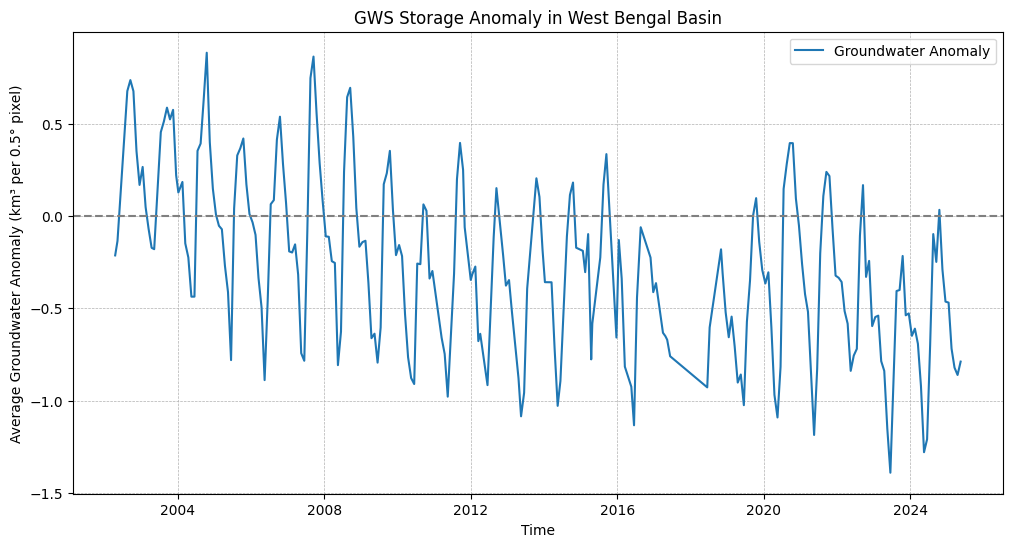

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your final file with the per-pixel GWS data ---
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 1: Select the necessary columns ---
gws_timeseries = final_df[['time', 'GWS_anomaly_km3']].copy()

# --- Step 2: Aggregate to a single basin-wide time series ---
# The reference code uses .mean() to get the average GWS anomaly across all grid cells for each month.
# Note: You could use .sum() to get the total volume anomaly for the entire basin.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 3: Create the plot ---
print("Generating the final time-series plot...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
plt.plot('time', 'GWS_anomaly_km3', data=gws_basin_avg, label='Groundwater Anomaly')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
plt.title('GWS Storage Anomaly in West Bengal Basin')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (km³ per 0.5° pixel)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## --- Configuration ---
year_to_plot = 2021
month_to_plot = 8  # April

# --- File paths ---
gws_file = 'NOAH_GWS_Final_Results_per_Pixel.csv'
shapefile_path = r'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'

## --- Step 1: Load Data ---
print(f"Loading data to create a map for {year_to_plot}-{month_to_plot:02d}...")
final_df = pd.read_csv(gws_file)
final_df['time'] = pd.to_datetime(final_df['time'])
basin_shapefile = gpd.read_file(shapefile_path)

## --- Step 2: Filter by Year and Month ---
mask = (final_df['time'].dt.year == year_to_plot) & (final_df['time'].dt.month == month_to_plot)
gws_for_date = final_df[mask].copy()

if gws_for_date.empty:
    print(f"Error: No data found for {year_to_plot}-{month_to_plot:02d}.")
else:
    ## --- Step 3: Prepare Spatial Data ---
    geometries = []
    for index, row in gws_for_date.iterrows():
        lon, lat = row['lon'], row['lat']
        lon_point_list = [lon - 0.25, lon + 0.25, lon + 0.25, lon - 0.25, lon - 0.25]
        lat_point_list = [lat - 0.25, lat - 0.25, lat + 0.25, lat + 0.25, lat - 0.25]
        geometries.append(Polygon(zip(lon_point_list, lat_point_list)))

    gws_gdf = gpd.GeoDataFrame(gws_for_date, geometry=geometries, crs="EPSG:4326")

    ## --- Step 4: Clip the Data Grid to the Shapefile ---
    print("Synchronizing and clipping data...")
    basin_shapefile = basin_shapefile.to_crs(gws_gdf.crs)
    gws_clipped = gpd.clip(gws_gdf, basin_shapefile)

    ## --- Step 5: Create the Final Map ---
    if gws_clipped.empty:
        print("Error: The clipped dataset is empty.")
    else:
        print("Generating map with reversed color scheme...")

        v_abs = gws_clipped['GWS_anomaly_km3'].abs().quantile(0.95)
        vmin, vmax = -v_abs, v_abs

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        gws_clipped.plot(column='GWS_anomaly_km3', 
                         ax=ax, 
                         legend=True,
                         legend_kwds={'label': "Groundwater Anomaly (km³)", 'orientation': "horizontal"},
                         cmap='RdYlBu_r', # THE FIX: The '_r' reverses the colormap
                         vmin=vmin,
                         vmax=vmax)

        basin_shapefile.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

        ax.set_title(f'Groundwater Storage Anomaly in West Bengal\n({year_to_plot}-{month_to_plot:02d})', fontsize=16)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, linestyle='--', linewidth=0.5)

        plt.show()

Loading data to create a map for 2021-09...


FileNotFoundError: [Errno 2] No such file or directory: 'NOAH_GWS_Final_Results_per_Pixel.csv'